<a href="https://colab.research.google.com/github/SaranAI/thaichar2vec/blob/main/notebooks/research/train_gloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About this notebook
- This notebook implemented GloVe model on thai corpus to obtain thai embedding
- Although most cases are better ะน use (sub)word over character embedding, however, it might be useful for some cases like
1. name generation
2. thai word cut

## Goal
- To maximize the entropy of the work in corpus

## Method
- Obtain Corpora
  - name-surname corpus
  - thai vocabulary ฉบับราชบั
- Train
  - skipgram
  - cbow
  - negative samples
  - glove
- Visualize

## Why GloVe

The primary drawback of window-based methods is their limited scope; they focus on local context and do not consider global co-occurrences, which means they overlook valuable statistical information within the corpus. Consequently, they fail to harness the patterns of word repetition found throughout the corpus

In [ ]:
# Import Data
%%capture

# Name-surname corpus
!wget -O male_name.txt https://raw.githubusercontent.com/SaranAI/thaichar2vec/main/artifacts/dataset/male_names_th.txt
!wget -O female_name.txt https://raw.githubusercontent.com/SaranAI/thaichar2vec/main/artifacts/dataset/female_names_th.txt
!wget -O surname.txt https://raw.githubusercontent.com/SaranAI/thaichar2vec/main/artifacts/dataset/surnames_th.txt

# Thai Lexicon Vocabulary
!wget -O lexicon.txt https://raw.githubusercontent.com/SaranAI/thaichar2vec/main/artifacts/dataset/lexicon_th.txt

In [ ]:
from typing import List, Set, Union, Dict, Tuple
import os

# Define functions
def open_txt(txt_file:str)->List:
  """
  Read lines from txt file and return a list where
  each list element represent each line
  """
  output_list = []
  with open(txt_file,"r") as f:
    lines = f.readlines()
    for line in lines:
     output_list.append(line.strip())
  return output_list

def get_corpora(corpus_file_names:List[str],
                root_dir:str="/content",
                verbose=True)->Set[str]:

  """
  Import all corpus files

  Output:
    - set of all words (set)
  """

  corpus_list = []
  for corpus_file_name in corpus_file_names:
    corpus = open_txt(os.path.join(root_dir,corpus_file_name))
    print(f"len({corpus_file_name})={len(corpus)}") if verbose else None
    corpus_list.append(corpus)

  corpora = set()
  for corpus in corpus_list:
    corpora.update(corpus)

  print(f"{len(corpora)=}") if verbose else None
  return corpora

In [ ]:
corpus_file_name = ["male_name.txt",
                    "female_name.txt",
                    "surname.txt",
                    "lexicon.txt"]

corpora = get_corpora(corpus_file_name,verbose=True)

len(male_name.txt)=7124
len(female_name.txt)=5098
len(surname.txt)=9836
len(lexicon.txt)=37675
len(corpora)=56983


- We found some of vocabulary word contain no thai character, so we will remove the word contain that out,

In [ ]:
WHITELIST = list("กขฃคฅฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬอฮฤฦะัาำิีึืุูเแโใไๅํ็่้๊๋ฯฺๆ์ํ")
# Pop duplicated
WHITELIST = sorted(list(set(WHITELIST)))

def preprocess(corpus:Set[str],
               whitelist:Union[List,str]=WHITELIST,
               verbose:bool=True)->Set[str]:
  """
  Perform preprocessing to the vocabulary inside corpus

  Note:
    This function mutates the corpus in-place
  """
  # REF:Obtain and partially remove some from Pythainlp.thai_characters

  for word in corpus.copy():
    # Inspect in character level
    for char in word:
      if char not in whitelist:
        corpus.remove(word)
        print(f'Remove word "{word}" containing "{char}"') if verbose else None
        break

  print(f"{len(corpus)=}" if verbose else None)
  return corpus

In [ ]:
corpora = preprocess(corpora, WHITELIST)

Remove word "พสก-" containing "-"
Remove word "ชาต-" containing "-"
Remove word "เอาหูไปนา เอาตาไปไร่" containing " "
Remove word "สิญจ-" containing "-"
Remove word "สาณ-" containing "-"
Remove word "เนือย ๆ" containing " "
Remove word "บรม-" containing "-"
Remove word "ยิบ ๆ" containing " "
Remove word "ฝนตกก็แช่ง ฝนแล้งก็ด่า" containing " "
Remove word "ปาฐ-" containing "-"
Remove word "วาร-" containing "-"
Remove word "คิก ๆ" containing " "
Remove word "ด๊ก ๆ" containing " "
Remove word "ภาร-" containing "-"
Remove word "ลูก ๆ หลาน ๆ" containing " "
Remove word "ชน-" containing "-"
Remove word "หย็อย ๆ" containing " "
Remove word "วันทน-" containing "-"
Remove word "นิสภ-" containing "-"
Remove word "ความวัวไม่ทันหาย ความควายเข้ามาแทรก" containing " "
Remove word "ด่อง ๆ" containing " "
Remove word "ดาด ๆ" containing " "
Remove word "พิษ-" containing "-"
Remove word "คร่าว ๆ" containing " "
Remove word "อภินันท-" containing "-"
Remove word "อัฐ-" containing "-"
Remove word "โคจร-" c

- Make sure that the all characters from whitelist was contained in this corpus

In [ ]:
def check_diff_charset(corpus:Set[str],
                       whitelist:Union[List[str],str])->Set[str]:
  """
    Check and return the difference in character sets between a corpus of words and a whitelist.

    Args:
        corpus (Set[str]): A set of words to examine for character set differences.
        whitelist (Union[List[str], str]): A whitelist of characters (either a list of characters or a string).

    Returns:
        Set[str]: A set of characters present in the whitelist but not in the corpus.
    """
  whitelist_charset = set(whitelist)
  corpus_charset = set()
  for word in corpus:
    # Inspect in character level
    for char in word:
      corpus_charset.add(char)

  diff_charset = whitelist_charset.difference(corpus_charset)
  return diff_charset


In [ ]:
diff_charset = check_diff_charset(corpora,WHITELIST)

# Since our corpus does not contain
# Get Corpus Char list
CHARLIST = WHITELIST.copy()
for diff_char in diff_charset:
  CHARLIST.remove(diff_char)

In [ ]:
# Initiate some type hint
from typing import TypedDict
from collections import OrderedDict

def make_vocabulary(charlist:List[str],
                    add_special_token:bool=True)->Dict[str,int]:
  """
  Make vocabulary where a key represent character token and a value represent id token from character list

  Args:
  1. charlist
    A list of character token derived from the corpus
  2. add_special_token :
    adding the special tokn which does not derived from input containing <UNK>

  Example:
    vocabulary = {"ก" : 0,
                  "ข" : 1,
                  "ค" : 2}
  """
  vocabulary = OrderedDict()

  # Add Special Token
  if add_special_token:
    special_token_list = ["<pad>","<unk>"]
    for i,char in enumerate(special_token_list):
      vocabulary.update({char : i})

  # Add char from charlist
  start_idx = len(vocabulary)
  for i,char in enumerate(charlist,start_idx):
    vocabulary.update({char : i})

  return vocabulary

In [ ]:
vocabulary = make_vocabulary(CHARLIST)
reverse_vocabulary = {v: k for k, v in vocabulary.items()}
print(f"{len(vocabulary)=}")
# vocab

len(vocabulary)=71


In [ ]:
# Let check total characters
from functools import reduce
total_char_sum = reduce(lambda x, y: x + len(y), corpora, 0)
print(f"Total characters in corpus : {total_char_sum}")

Total characters in corpus : 416715


## Make Dataset for each architecture
- GloVe Co-occurence matrix



### 1. GloVe ▶



#### Make DataFrame

In [ ]:
# We need sparse matrix with size 70x70
def token_to_id_string(string,
                       vocabulary:Dict[str,int])->List[int]:
  """
    Map word to id
  """
  lst = list(string)
  unk_id = vocabulary.get("<unk>")
  tok_lst = list(map(lambda x :vocabulary.get(x,unk_id),lst))
  return tok_lst

In [ ]:
token_to_id_string("กินนี่",vocabulary)

[2, 52, 26, 26, 53, 65]

In [ ]:
import numpy as np
def make_glove_dataset(corpus:str,
                       vocabulary,
                       window_size:int=2,
                       laplace_smoothing:bool=False)->np.ndarray:

  """
  Laplace smoothing is not recommended to counter log of zero problem, it's still have weight problem
  """
  # {(2,4) : 3, (1,10) : 4}
  num_tokens = len(vocabulary)
  co_occurrence_matrix = (np.ones((num_tokens, num_tokens), dtype=int) if laplace_smoothing
                          else np.zeros((num_tokens, num_tokens), dtype=int))

  for word in corpus:
    co_counts:Dict[tuple,int] = make_glove_row(word,
                                               vocabulary,
                                               window_size)

    for (char_pair,count) in co_counts.items():
      context_id, target_id = char_pair
      co_occurrence_matrix[context_id][target_id] += count

  return co_occurrence_matrix

def make_glove_row(word:str,
                   vocabulary:Dict[str,int],
                   window_size:int=2)->Dict[tuple,int]:

  """
  Return a pair of co-occurence count of word i and j
  """
  add_pad_token = "<pad>" in vocabulary.keys()
  co_counts = dict()

  for idx in range(len(word)):
    # assign the current char
    char = word[idx]

    # Get prior index
    prev_idx = idx - window_size
    next_idx = idx + window_size

    # Create new instance where context as previous
    for i in range(prev_idx,idx):
      # Context as pad if out of border
      if i < 0:
        if add_pad_token:
          char_pair = (char,"<pad>")
        else:
          # Skip if not add_pad_token
          continue
      else:
        char_pair = (char,word[i])

      # Turn token to id
      char_pair = tuple(map(vocabulary.get,char_pair))
      # Update count
      if co_counts.get(char_pair):
        co_counts[char_pair] += 1
      else:
        co_counts[char_pair] = 1

    # Create new instance where context as next
    for i in range(idx+1,next_idx+1):
      # Create new instance
      if i > len(word)-1:
        if add_pad_token:
          char_pair = (char,"<pad>")
        else:
          # Skip if not add_pad_token
          continue
      else:
        char_pair = (char,word[i])

      # Turn token to id
      char_pair = tuple(map(vocabulary.get,char_pair)) # (vocabulary[char_pair[0]],vocabulary[char_pair[1]])
      # Update count
      if co_counts.get(char_pair):
        co_counts[char_pair] += 1
      else:
        co_counts[char_pair] = 1
  return co_counts

In [ ]:
from scipy import sparse

sample_corpus = ["กินไก่","ไอนน"]
co_occurrence_matrix = make_glove_dataset(sample_corpus,vocabulary,1)
sparse = sparse.csr_matrix(co_occurrence_matrix)
print(sparse)

  (2, 0)	1
  (2, 52)	1
  (2, 62)	1
  (2, 65)	1
  (26, 0)	1
  (26, 26)	2
  (26, 46)	1
  (26, 52)	1
  (26, 62)	1
  (46, 26)	1
  (46, 62)	1
  (52, 2)	1
  (52, 26)	1
  (62, 0)	1
  (62, 2)	1
  (62, 26)	1
  (62, 46)	1
  (65, 0)	1
  (65, 2)	1


In [ ]:
co_occurrence_matrix = make_glove_dataset(corpora,vocabulary,1,laplace_smoothing=False)
co_occurrence_matrix

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [6242,    0,  578, ...,   21,  142,    0],
       ...,
       [  27,    0,   21, ...,    0,    0,    0],
       [7484,    0,  142, ...,    0,    2,    0],
       [   0,    0,    0, ...,    0,    0,    0]])

In [ ]:
import matplotlib.pyplot as plt

# Setup Thai font first
import matplotlib as mpl
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
mpl.font_manager.fontManager.addfont("/content/thsarabunnew-webfont.ttf")
mpl.rc("font",family="TH Sarabun New", size=20)

def visualize_co_occurence_matrix(co_occurrence_matrix,
                                  vocabulary):
    assert co_occurrence_matrix.shape[0] == len(vocabulary), "Make sure the width and height are equal to len(vocabulary)"
    plt.figure(figsize=(25, 22))
    plt.imshow(co_occurrence_matrix, cmap='viridis')  # You can change the colormap ('viridis' in this example)
    plt.colorbar()  # Add a colorbar for reference

    # Set custom tick labels
    tick_positions = np.arange(len(vocabulary))
    tick_labels = vocabulary

    # Set the tick positions and labels on both axes
    plt.xticks(tick_positions, tick_labels, rotation=90)
    plt.yticks(tick_positions, tick_labels)
    plt.tight_layout()

    plt.show()

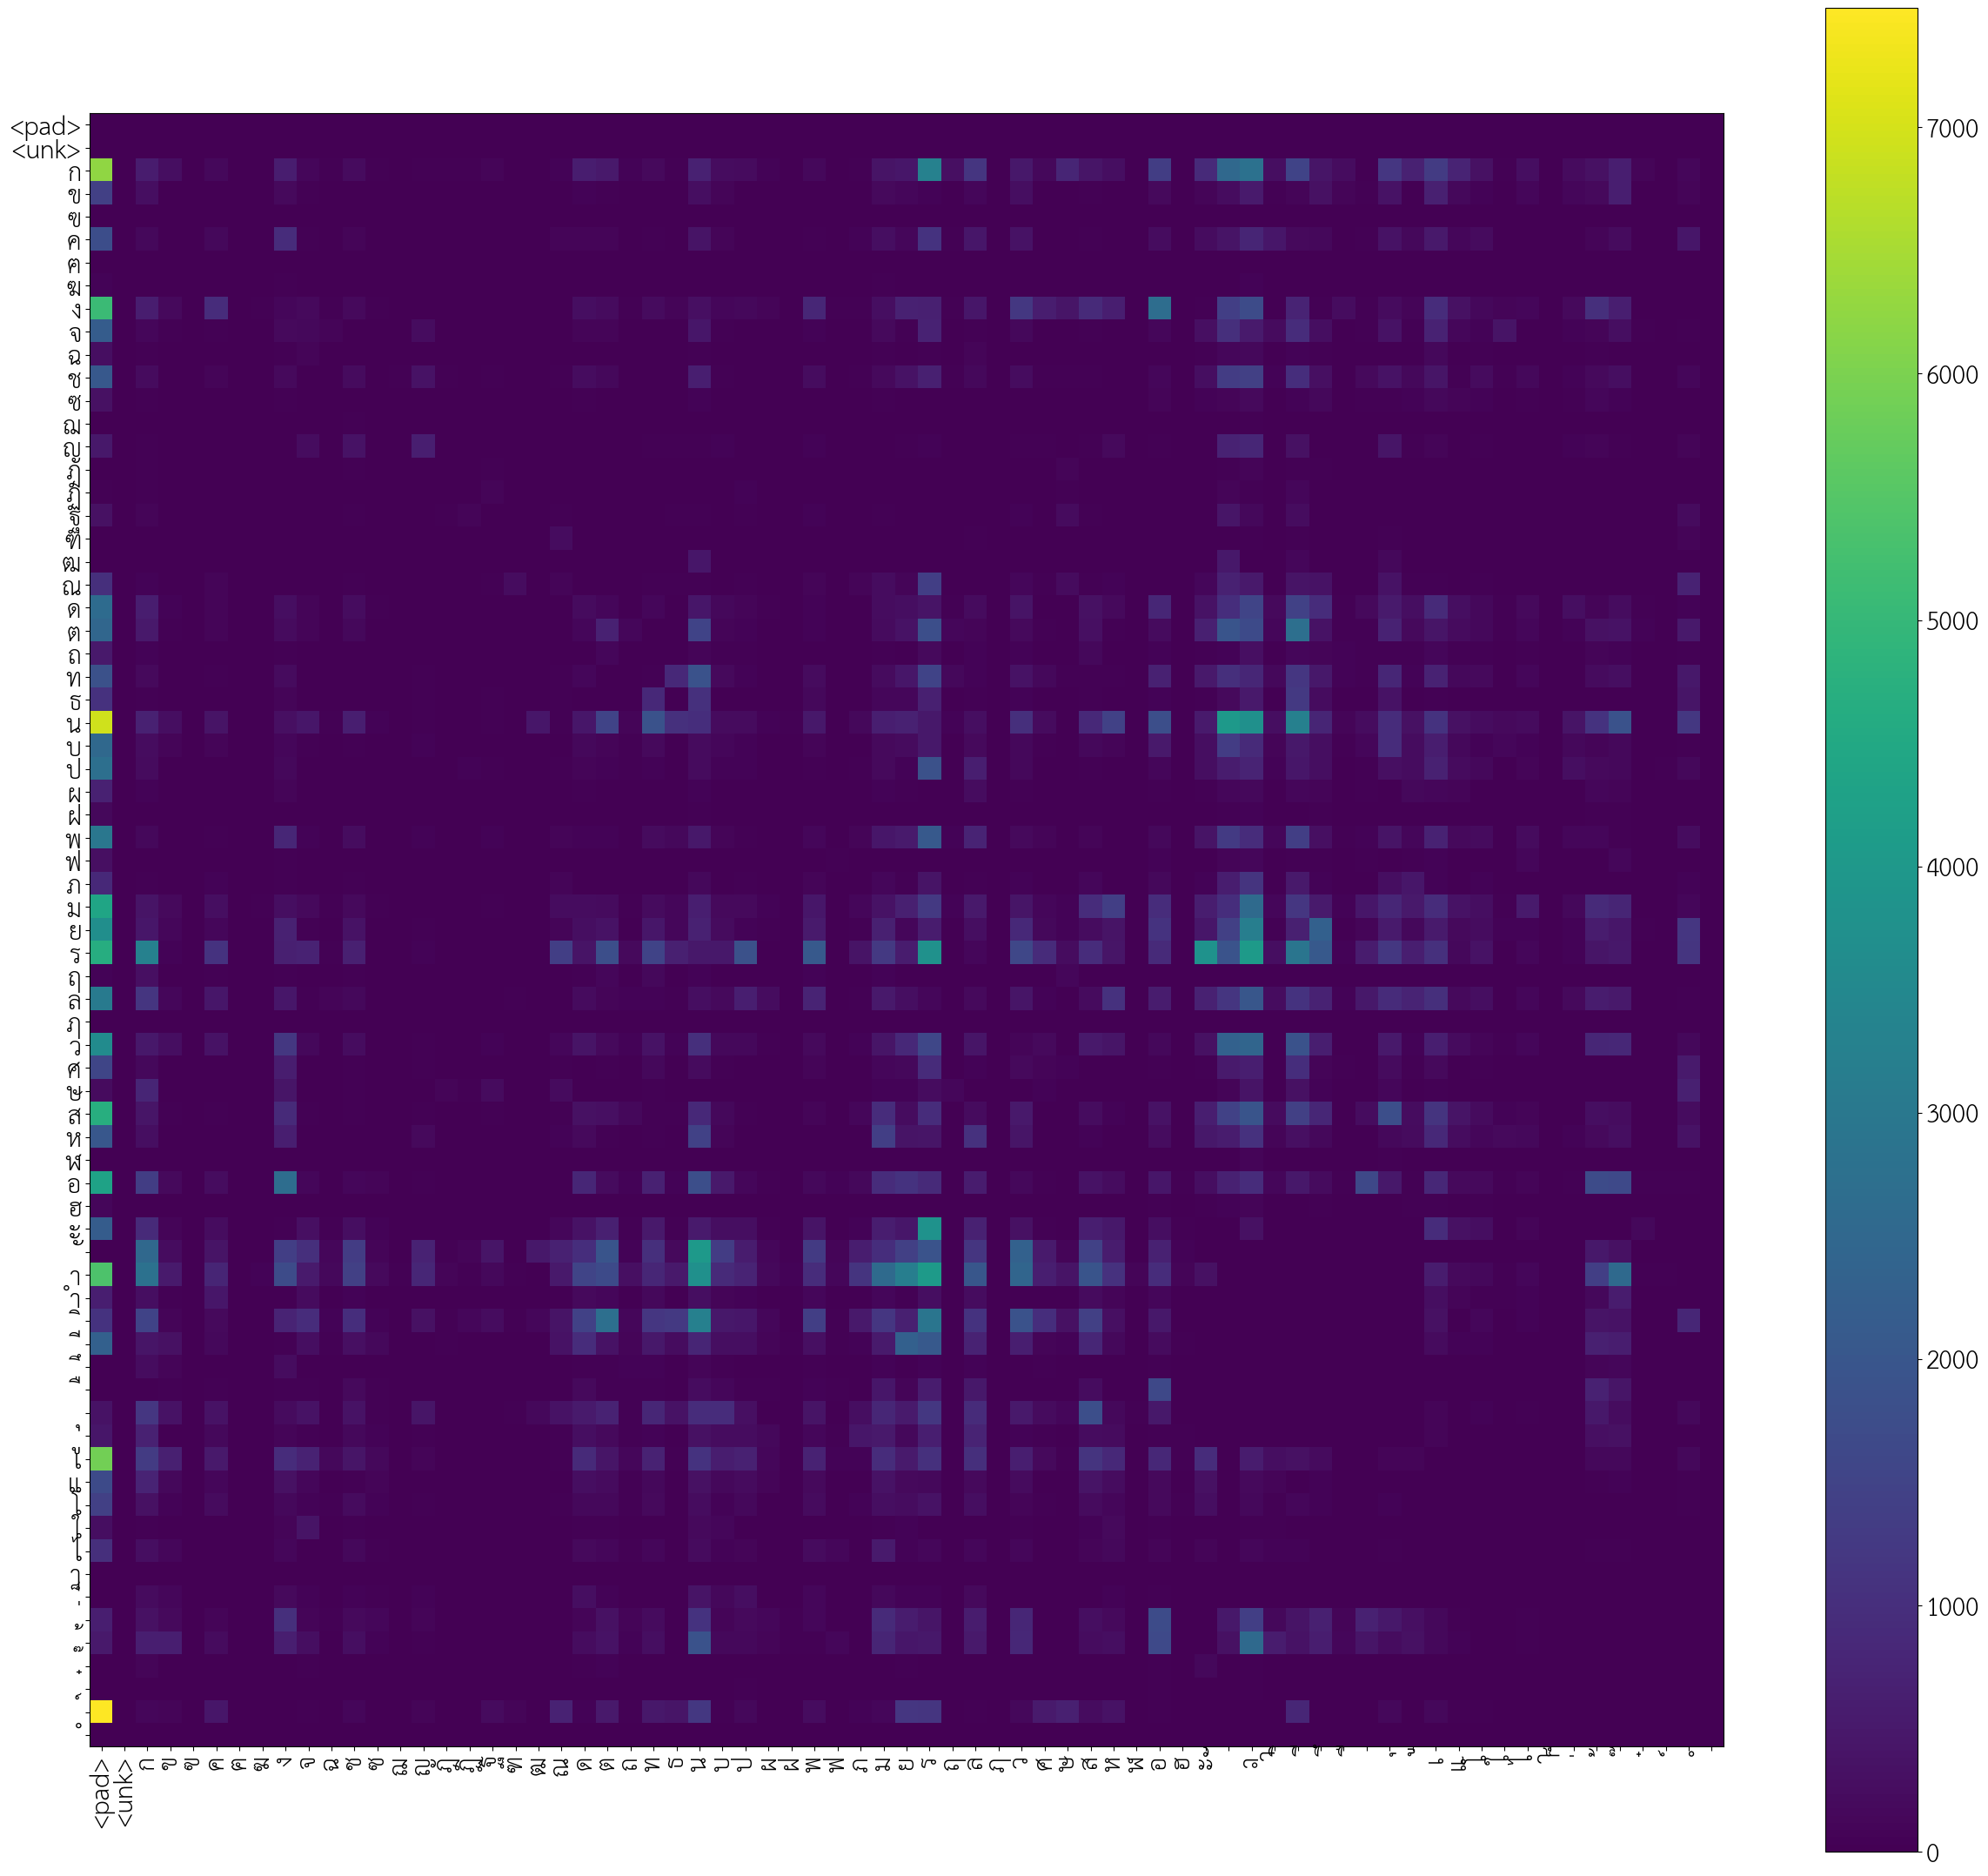

In [ ]:
visualize_co_occurence_matrix(co_occurrence_matrix,vocabulary)

#### Make Torch Dataset & Loader

In [ ]:
# Define a custom dataset
import torch
from torch.utils.data import DataLoader, Dataset
# Do we need ?
class GloveDataset(Dataset):
    # We only need labels as cooccurrence matrix
    def __init__(self,
                 co_occurrence_matrix:np.ndarray,
                 transform=None):
        self.co_occurrence_matrix = co_occurrence_matrix

    def __len__(self):
        return self.co_occurrence_matrix.size

    def __getitem__(self, index):
        # NOTE : The maximum number of index is (vocab_size x vocab_size)
        # Calculate the context_idx and target_idx based on the index
        num_rows, num_cols = self.co_occurrence_matrix.shape
        context_idx = index // num_cols
        target_idx = index % num_cols

        # Retrieve the co-occurrence count
        co_count = self.co_occurrence_matrix[context_idx][target_idx]

        return {"context_idx" : context_idx,
                "target_idx" : target_idx,
                "co_count" : co_count}


In [ ]:
glove_dataset = GloveDataset(co_occurrence_matrix)
print(f"{len(glove_dataset) = }")

len(glove_dataset) = 5041


In [ ]:
# See the data of some indixes
print(f"{glove_dataset[5011] = }")
print(f"{glove_dataset[100] = }")
print(f"{glove_dataset[2400] = }")

glove_dataset[5011] = {'context_idx': 70, 'target_idx': 41, 'co_count': 0}
glove_dataset[100] = {'context_idx': 1, 'target_idx': 29, 'co_count': 0}
glove_dataset[2400] = {'context_idx': 33, 'target_idx': 57, 'co_count': 446}


In [ ]:
batch_size = 128
glove_loader = DataLoader(glove_dataset, batch_size, shuffle=True)

In [ ]:
# Instantiate function which return whole final dataloader from corpora and vocabulary
def make_glove_loader(corpora,
                      vocabulary,
                      window_size=2,
                      batch_size=128,
                      laplace_smoothing=False):
    co_occurrence_matrix = make_glove_dataset(corpora,vocabulary,1,laplace_smoothing)
    glove_dataset = GloveDataset(co_occurrence_matrix)
    glove_loader = DataLoader(glove_dataset, batch_size, shuffle=True)
    return glove_loader

In [ ]:
glove_loader = make_glove_loader(corpora, vocabulary, batch_size=128, laplace_smoothing=False)

#### Make Architecture

- Since our dataset split into a pair of context and target individually
  - Instead of (1 -> (0,3))
    We split into (1,0), (1,3)
  - So, the architecture for both method `skipgram` and `cbow` are the same

  ![skipgram](https://www.researchgate.net/publication/322905432/figure/fig1/AS:614314310373461@1523475353979/The-architecture-of-Skip-gram-model-20.png)

  - We treat each pair of target and different context as different instance
  - Hence, let's called word2vec architecture

In [ ]:
# Define a simple neural network model
import torch.nn as nn
import torch.nn.functional as F
import torch

class GloveModel(nn.Module):
    def __init__(self,vocab_size, emb_size):
      # Input as context and target embedding matrix
      super(GloveModel, self).__init__()
      self.context_embedding = nn.Embedding(vocab_size, emb_size)
      self.target_embedding = nn.Embedding(vocab_size, emb_size)

      # Each character have its own bias
      self.context_bias = nn.Embedding(vocab_size,1)
      self.target_bias = nn.Embedding(vocab_size,1)

    def forward(self,context,target):
        # Find similarity between context embedding of word i and target embedding of word j first
        x = self.context_embedding(context) @ self.target_embedding(target).T

        # Add bias of context and target
        x = x + self.context_bias(context) + self.target_bias(target)
        return x

- ⚠ Note : embedding layer take input token as input not the one hot encoding unlike linear layer
- This is why our dataset does not convert id token into one hot

In [ ]:
def test_forward_glove():
  # Generate two one-hot vector : One hot for class 2 and 10 with size 71
  context_id = torch.tensor(2,dtype=torch.long)
  target_id = torch.tensor(50,dtype=torch.long)
  vocab_size = 71

  # Initiate model
  glove_model = GloveModel(vocab_size,32)
  # Test Forward
  out = glove_model(context_id,target_id)
  return out

out = test_forward_glove()
out

<ipython-input-24-3fc8122f8cf5>:19: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  x = self.context_embedding(context) @ self.target_embedding(target).T


tensor([-1.8205], grad_fn=<AddBackward0>)

#### Make Trainer
- Use to be a medium for training data and architecture
- Input (X) will be forwarding propogation via our architecture and return a scalar ( which hopefully near the log of co-count of context and target word)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

device=device(type='cuda')


##### Make Loss function (Criterion)

- For simplicity, The loss is equal to scalar - log(X_ij) for a context word i and target word j
- Since it assigns equal importance to all instances of co-occurrence, even those that occur infrequently or never occur at all. These infrequent co-occurrences are considered to be less informative and can introduce noise, to tackle this problem, We need a weight for each different pair of context and target word, hence our loss function for all pairs of word is $\sum_{i\in\mathcal{V}} \sum_{j\in\mathcal{V}} f(x_{ij}) \left(\mathbf{u}_j^\top \mathbf{v}_i + b_i + c_j - \log\,x_{ij}\right)^2$

    - The pair of word with high co-count deserve to be more focus than low co-count, hence we need a weight function (f(x_ij)) which take co-count frequency (X_ij) as input, i.e. higher X_ij -> higher weight, lower X_ij -> lower weight

    - From [GloVe Paper](https://nlp.stanford.edu/pubs/glove.pdf), the weight function they used is the following piecewise function
    ![](https://i.ibb.co/hWHX2Sy/Screenshot-2023-10-14-121531.png)

    ![](https://i.ibb.co/8Kr9Fq8/Screenshot-2023-10-14-121216.png)

In [ ]:
from functools import partial
# Let's define our loss function (criterion)

def weighted_mse_loss(input, target, weight):
    # weight will be corresponding to target
    return (weight * (input - target) ** 2).mean()

def glove_weight_function(x, xmax = 100, alpha=0.75):
    """
    Return weight from the given x (co-occurence frequency)
    """
    # Ignore if these words are not co-count
    if x <= 0:
        return 0

    # Saturated
    elif x < xmax:
        return 1

    else:
        return (x/xmax)**alpha

##### Make trainer

In [ ]:
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import os

def train_step(model, inputs, labels, criterion, optimizer, device):
  optimizer.zero_grad()
  context_idx, target_idx = inputs

  # Move data to device
  weights = labels.apply_(glove_weight_function)
  context_idx = context_idx.to(device)
  target_idx = target_idx.to(device)
  labels = labels.to(device)
  weights = weights.to(device)

  # Forward
  outputs = model(context_idx, target_idx)  # Scalar

  # Backward
  loss = criterion(outputs, labels, weights)
  loss.backward()
  optimizer.step()

  return loss.item()

def train_epoch(model, train_loader, criterion, optimizer, device):
  total_loss = 0.0
  loop = tqdm(train_loader,desc="Training")

  for i, data in enumerate(loop):
    context_idx = data["context_idx"]
    target_idx = data["target_idx"]
    co_count = data["co_count"]
    inputs = (context_idx, target_idx)
    labels = co_count
    loss = train_step(model, inputs, labels, criterion, optimizer, device)
    total_loss += loss
    loop.set_postfix(loss=loss)
  return total_loss

def train(model,
          train_loader,
          criterion,
          optimizer,
          model_path:str,
          num_epochs=5,
          device='cuda'):
  """

  Arg:
    model_path - the destination path that store best model as best.pt and final model as final.pt
  """
  best_loss = np.inf
  model.to(device)
  for epoch in range(num_epochs):
    total_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    mean_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Loss: {mean_loss}")
    # Save best model
    if best_loss > mean_loss:
      best_loss = mean_loss
      print(f"Best model saved at epoch {epoch + 1}")
      torch.save(model.state_dict(), os.path.join(model_path,'best.pth'))

  # Save Final model
  print(f"Final model saved at epoch {epoch + 1}")
  torch.save(model.state_dict(), os.path.join(model_path,'final.pth'))
  final_loss = mean_loss
  return model, best_loss, final_loss

#### Start training CBOW

In [ ]:
# Mount to store model in here
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from datetime import datetime
now = datetime.now()
now = now.strftime("%Y-%m-%d %H:%M:%S")

In [ ]:
import os
import json
from datetime import datetime

# Initiate meta
vocab_size = len(vocabulary)
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
model_path = f'/content/drive/MyDrive/thaichar2vec/glove/{now}'
if not os.path.exists(model_path): os.makedirs(model_path) # Make directory if not exist

# Define Hyperparameter
add_special_token = False
laplace_smoothing = False
batch_size = 256
emb_size = 32
num_epochs = 300
learning_rate = 1e-3
window_size = 1

# Create Vocabulary
vocabulary = make_vocabulary(CHARLIST,add_special_token)
reverse_vocabulary = {v: k for k, v in vocabulary.items()}
print(f"{len(vocabulary)=}")

# Create Loader
glove_loader = make_glove_loader(corpora,
                                vocabulary,
                                window_size,
                                batch_size,
                                 device)

# Define LOAD
vocab_size = len(vocabulary)
model = GloveModel(vocab_size,emb_size).to(device)
criterion = weighted_mse_loss

# Criterion as sigmoid if isNegativeSampling
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Write model metadata
with open(os.path.join(model_path,"hyperparameter.json"),"w") as f:
  dictionary = dict(add_special_token=add_special_token,
                    batch_size=batch_size,
                    emb_size=emb_size,
                    num_epochs=num_epochs,
                    learning_rate=learning_rate,
                    window_size=window_size)

  json_object = json.dumps(dictionary, indent=4)
  f.write(json_object)

# Start training CBOW
model, best_loss, final_loss = train(model,
                                    glove_loader,
                                    criterion,
                                    optimizer,
                                    model_path,
                                    num_epochs)

# Submit Result
with open(os.path.join(model_path,"result.json"),"w") as f:
  dictionary = dict(best_loss=best_loss,
                    final_loss=final_loss)

  json_object = json.dumps(dictionary, indent=4)
  f.write(json_object)

len(vocabulary)=69


Training: 100%|██████████| 19/19 [00:00<00:00, 291.77it/s, loss=126]


Epoch [1/300] Loss: 84.41888146651418
Best model saved at epoch 1


Training: 100%|██████████| 19/19 [00:00<00:00, 307.50it/s, loss=72.9]


Epoch [2/300] Loss: 79.71367103175113
Best model saved at epoch 2


Training: 100%|██████████| 19/19 [00:00<00:00, 292.77it/s, loss=66.7]


Epoch [3/300] Loss: 76.98688386615954
Best model saved at epoch 3


Training: 100%|██████████| 19/19 [00:00<00:00, 285.86it/s, loss=67.1]


Epoch [4/300] Loss: 74.544804824026
Best model saved at epoch 4


Training: 100%|██████████| 19/19 [00:00<00:00, 312.06it/s, loss=106]


Epoch [5/300] Loss: 72.55808940686677
Best model saved at epoch 5


Training: 100%|██████████| 19/19 [00:00<00:00, 290.88it/s, loss=56.4]


Epoch [6/300] Loss: 68.94166303935803
Best model saved at epoch 6


Training: 100%|██████████| 19/19 [00:00<00:00, 292.94it/s, loss=41.2]


Epoch [7/300] Loss: 66.51010714079204
Best model saved at epoch 7


Training: 100%|██████████| 19/19 [00:00<00:00, 307.55it/s, loss=54.4]


Epoch [8/300] Loss: 64.47284015856292
Best model saved at epoch 8


Training: 100%|██████████| 19/19 [00:00<00:00, 311.59it/s, loss=44.4]


Epoch [9/300] Loss: 62.29140251561215
Best model saved at epoch 9


Training: 100%|██████████| 19/19 [00:00<00:00, 299.77it/s, loss=42.2]


Epoch [10/300] Loss: 60.0890834206029
Best model saved at epoch 10


Training: 100%|██████████| 19/19 [00:00<00:00, 315.04it/s, loss=50.7]


Epoch [11/300] Loss: 58.54291474191766
Best model saved at epoch 11


Training: 100%|██████████| 19/19 [00:00<00:00, 292.89it/s, loss=39.4]


Epoch [12/300] Loss: 56.39019594694439
Best model saved at epoch 12


Training: 100%|██████████| 19/19 [00:00<00:00, 288.72it/s, loss=69.8]


Epoch [13/300] Loss: 55.461010581568665
Best model saved at epoch 13


Training: 100%|██████████| 19/19 [00:00<00:00, 311.52it/s, loss=53.8]


Epoch [14/300] Loss: 53.10780475014135
Best model saved at epoch 14


Training: 100%|██████████| 19/19 [00:00<00:00, 290.87it/s, loss=67.3]


Epoch [15/300] Loss: 51.85571309139854
Best model saved at epoch 15


Training: 100%|██████████| 19/19 [00:00<00:00, 308.32it/s, loss=37.6]


Epoch [16/300] Loss: 49.81673632170025
Best model saved at epoch 16


Training: 100%|██████████| 19/19 [00:00<00:00, 311.48it/s, loss=61.6]


Epoch [17/300] Loss: 48.727485154804434
Best model saved at epoch 17


Training: 100%|██████████| 19/19 [00:00<00:00, 294.39it/s, loss=40.7]


Epoch [18/300] Loss: 46.71237142462479
Best model saved at epoch 18


Training: 100%|██████████| 19/19 [00:00<00:00, 317.37it/s, loss=81.3]


Epoch [19/300] Loss: 46.3193503931949
Best model saved at epoch 19


Training: 100%|██████████| 19/19 [00:00<00:00, 291.66it/s, loss=25.2]


Epoch [20/300] Loss: 43.867420497693516
Best model saved at epoch 20


Training: 100%|██████████| 19/19 [00:00<00:00, 307.14it/s, loss=51.3]


Epoch [21/300] Loss: 43.035079554507604
Best model saved at epoch 21


Training: 100%|██████████| 19/19 [00:00<00:00, 294.86it/s, loss=28.9]


Epoch [22/300] Loss: 41.16259002685547
Best model saved at epoch 22


Training: 100%|██████████| 19/19 [00:00<00:00, 307.30it/s, loss=39]


Epoch [23/300] Loss: 40.26107828240646
Best model saved at epoch 23


Training: 100%|██████████| 19/19 [00:00<00:00, 304.02it/s, loss=37.1]


Epoch [24/300] Loss: 39.28783336438631
Best model saved at epoch 24


Training: 100%|██████████| 19/19 [00:00<00:00, 275.88it/s, loss=26.1]


Epoch [25/300] Loss: 37.6604713640715
Best model saved at epoch 25


Training: 100%|██████████| 19/19 [00:00<00:00, 270.22it/s, loss=67.7]


Epoch [26/300] Loss: 37.4832225598787
Best model saved at epoch 26


Training: 100%|██████████| 19/19 [00:00<00:00, 267.09it/s, loss=54.3]


Epoch [27/300] Loss: 36.23695373535156
Best model saved at epoch 27


Training: 100%|██████████| 19/19 [00:00<00:00, 270.71it/s, loss=22.1]


Epoch [28/300] Loss: 34.60135208932977
Best model saved at epoch 28


Training: 100%|██████████| 19/19 [00:00<00:00, 267.30it/s, loss=42.5]


Epoch [29/300] Loss: 33.923423265155996
Best model saved at epoch 29


Training: 100%|██████████| 19/19 [00:00<00:00, 266.69it/s, loss=20.1]


Epoch [30/300] Loss: 32.3022787194503
Best model saved at epoch 30


Training: 100%|██████████| 19/19 [00:00<00:00, 269.65it/s, loss=24.2]


Epoch [31/300] Loss: 31.608456360666377
Best model saved at epoch 31


Training: 100%|██████████| 19/19 [00:00<00:00, 264.60it/s, loss=43.5]


Epoch [32/300] Loss: 31.238738009804173
Best model saved at epoch 32


Training: 100%|██████████| 19/19 [00:00<00:00, 267.62it/s, loss=51.6]


Epoch [33/300] Loss: 30.44213696529991
Best model saved at epoch 33


Training: 100%|██████████| 19/19 [00:00<00:00, 273.93it/s, loss=25.3]


Epoch [34/300] Loss: 29.003230496456748
Best model saved at epoch 34


Training: 100%|██████████| 19/19 [00:00<00:00, 297.15it/s, loss=48.9]


Epoch [35/300] Loss: 28.773682644492702
Best model saved at epoch 35


Training: 100%|██████████| 19/19 [00:00<00:00, 268.69it/s, loss=14.6]


Epoch [36/300] Loss: 27.360753460934287
Best model saved at epoch 36


Training: 100%|██████████| 19/19 [00:00<00:00, 286.62it/s, loss=14.9]


Epoch [37/300] Loss: 26.694211608485173
Best model saved at epoch 37


Training: 100%|██████████| 19/19 [00:00<00:00, 303.86it/s, loss=22]


Epoch [38/300] Loss: 25.992884585731908
Best model saved at epoch 38


Training: 100%|██████████| 19/19 [00:00<00:00, 250.77it/s, loss=29.4]


Epoch [39/300] Loss: 25.43477921736868
Best model saved at epoch 39


Training: 100%|██████████| 19/19 [00:00<00:00, 270.73it/s, loss=51.5]


Epoch [40/300] Loss: 25.40222002330579
Best model saved at epoch 40


Training: 100%|██████████| 19/19 [00:00<00:00, 254.65it/s, loss=43.5]


Epoch [41/300] Loss: 24.478728193985788
Best model saved at epoch 41


Training: 100%|██████████| 19/19 [00:00<00:00, 299.58it/s, loss=17]


Epoch [42/300] Loss: 23.41666020845112
Best model saved at epoch 42


Training: 100%|██████████| 19/19 [00:00<00:00, 292.74it/s, loss=24.4]


Epoch [43/300] Loss: 22.957264147306745
Best model saved at epoch 43


Training: 100%|██████████| 19/19 [00:00<00:00, 260.40it/s, loss=16.3]


Epoch [44/300] Loss: 22.319172558031585
Best model saved at epoch 44


Training: 100%|██████████| 19/19 [00:00<00:00, 277.43it/s, loss=13.8]


Epoch [45/300] Loss: 21.746672931470368
Best model saved at epoch 45


Training: 100%|██████████| 19/19 [00:00<00:00, 273.29it/s, loss=15.8]


Epoch [46/300] Loss: 21.1914936868768
Best model saved at epoch 46


Training: 100%|██████████| 19/19 [00:00<00:00, 256.72it/s, loss=17.9]


Epoch [47/300] Loss: 20.909714196857653
Best model saved at epoch 47


Training: 100%|██████████| 19/19 [00:00<00:00, 271.82it/s, loss=14]


Epoch [48/300] Loss: 20.317752838134766
Best model saved at epoch 48


Training: 100%|██████████| 19/19 [00:00<00:00, 301.19it/s, loss=41.3]


Epoch [49/300] Loss: 20.575496121456748


Training: 100%|██████████| 19/19 [00:00<00:00, 285.44it/s, loss=14]


Epoch [50/300] Loss: 19.606795060007197
Best model saved at epoch 50


Training: 100%|██████████| 19/19 [00:00<00:00, 303.31it/s, loss=17.3]


Epoch [51/300] Loss: 19.14557040365119
Best model saved at epoch 51


Training: 100%|██████████| 19/19 [00:00<00:00, 285.81it/s, loss=17.7]


Epoch [52/300] Loss: 18.905106594688014
Best model saved at epoch 52


Training: 100%|██████████| 19/19 [00:00<00:00, 270.94it/s, loss=16.5]


Epoch [53/300] Loss: 18.42212902872186
Best model saved at epoch 53


Training: 100%|██████████| 19/19 [00:00<00:00, 278.22it/s, loss=22.8]


Epoch [54/300] Loss: 18.268131256103516
Best model saved at epoch 54


Training: 100%|██████████| 19/19 [00:00<00:00, 271.67it/s, loss=18.6]


Epoch [55/300] Loss: 17.874950910869398
Best model saved at epoch 55


Training: 100%|██████████| 19/19 [00:00<00:00, 252.07it/s, loss=18.3]


Epoch [56/300] Loss: 17.579943305567692
Best model saved at epoch 56


Training: 100%|██████████| 19/19 [00:00<00:00, 258.83it/s, loss=10.3]


Epoch [57/300] Loss: 17.234135979100277
Best model saved at epoch 57


Training: 100%|██████████| 19/19 [00:00<00:00, 274.29it/s, loss=18.6]


Epoch [58/300] Loss: 17.10619961588006
Best model saved at epoch 58


Training: 100%|██████████| 19/19 [00:00<00:00, 278.93it/s, loss=15]


Epoch [59/300] Loss: 16.754765058818617
Best model saved at epoch 59


Training: 100%|██████████| 19/19 [00:00<00:00, 296.20it/s, loss=13.6]


Epoch [60/300] Loss: 16.464846360056026
Best model saved at epoch 60


Training: 100%|██████████| 19/19 [00:00<00:00, 287.54it/s, loss=11.8]


Epoch [61/300] Loss: 16.19832626142
Best model saved at epoch 61


Training: 100%|██████████| 19/19 [00:00<00:00, 291.73it/s, loss=15.4]


Epoch [62/300] Loss: 15.995132596869217
Best model saved at epoch 62


Training: 100%|██████████| 19/19 [00:00<00:00, 311.43it/s, loss=10.1]


Epoch [63/300] Loss: 15.744699578536185
Best model saved at epoch 63


Training: 100%|██████████| 19/19 [00:00<00:00, 294.03it/s, loss=7.83]


Epoch [64/300] Loss: 15.43923054243389
Best model saved at epoch 64


Training: 100%|██████████| 19/19 [00:00<00:00, 284.51it/s, loss=9.61]


Epoch [65/300] Loss: 15.287269291124845
Best model saved at epoch 65


Training: 100%|██████████| 19/19 [00:00<00:00, 287.42it/s, loss=13]


Epoch [66/300] Loss: 15.204589392009535
Best model saved at epoch 66


Training: 100%|██████████| 19/19 [00:00<00:00, 299.45it/s, loss=14]


Epoch [67/300] Loss: 15.102492056394878
Best model saved at epoch 67


Training: 100%|██████████| 19/19 [00:00<00:00, 299.01it/s, loss=11.2]


Epoch [68/300] Loss: 14.833189111006888
Best model saved at epoch 68


Training: 100%|██████████| 19/19 [00:00<00:00, 298.68it/s, loss=8.92]


Epoch [69/300] Loss: 14.6642999147114
Best model saved at epoch 69


Training: 100%|██████████| 19/19 [00:00<00:00, 288.63it/s, loss=22.1]


Epoch [70/300] Loss: 14.724922933076558


Training: 100%|██████████| 19/19 [00:00<00:00, 292.53it/s, loss=20]


Epoch [71/300] Loss: 14.621939458345112
Best model saved at epoch 71


Training: 100%|██████████| 19/19 [00:00<00:00, 291.18it/s, loss=15.4]


Epoch [72/300] Loss: 14.348002734937166
Best model saved at epoch 72


Training: 100%|██████████| 19/19 [00:00<00:00, 290.82it/s, loss=15.5]


Epoch [73/300] Loss: 14.172135905215615
Best model saved at epoch 73


Training: 100%|██████████| 19/19 [00:00<00:00, 297.62it/s, loss=17.1]


Epoch [74/300] Loss: 14.094266791092721
Best model saved at epoch 74


Training: 100%|██████████| 19/19 [00:00<00:00, 293.86it/s, loss=7.85]


Epoch [75/300] Loss: 13.702121257781982
Best model saved at epoch 75


Training: 100%|██████████| 19/19 [00:00<00:00, 296.87it/s, loss=15.1]


Epoch [76/300] Loss: 13.799941564861097


Training: 100%|██████████| 19/19 [00:00<00:00, 304.18it/s, loss=9.91]


Epoch [77/300] Loss: 13.566731804295591
Best model saved at epoch 77


Training: 100%|██████████| 19/19 [00:00<00:00, 280.47it/s, loss=10.5]


Epoch [78/300] Loss: 13.526429778651186
Best model saved at epoch 78


Training: 100%|██████████| 19/19 [00:00<00:00, 276.49it/s, loss=7.19]


Epoch [79/300] Loss: 13.295060233065957
Best model saved at epoch 79


Training: 100%|██████████| 19/19 [00:00<00:00, 288.41it/s, loss=9.02]


Epoch [80/300] Loss: 13.259712369818436
Best model saved at epoch 80


Training: 100%|██████████| 19/19 [00:00<00:00, 307.79it/s, loss=9.82]


Epoch [81/300] Loss: 13.194826075905247
Best model saved at epoch 81


Training: 100%|██████████| 19/19 [00:00<00:00, 278.24it/s, loss=19.9]


Epoch [82/300] Loss: 13.307342177943179


Training: 100%|██████████| 19/19 [00:00<00:00, 295.20it/s, loss=8.84]


Epoch [83/300] Loss: 12.996426456852964
Best model saved at epoch 83


Training: 100%|██████████| 19/19 [00:00<00:00, 308.01it/s, loss=12.6]


Epoch [84/300] Loss: 12.964927246696071
Best model saved at epoch 84


Training: 100%|██████████| 19/19 [00:00<00:00, 309.21it/s, loss=7.76]


Epoch [85/300] Loss: 12.81044074108726
Best model saved at epoch 85


Training: 100%|██████████| 19/19 [00:00<00:00, 289.01it/s, loss=8.86]


Epoch [86/300] Loss: 12.72007377524125
Best model saved at epoch 86


Training: 100%|██████████| 19/19 [00:00<00:00, 301.46it/s, loss=31]


Epoch [87/300] Loss: 13.065168029383608


Training: 100%|██████████| 19/19 [00:00<00:00, 278.07it/s, loss=13.9]


Epoch [88/300] Loss: 12.671665166553698
Best model saved at epoch 88


Training: 100%|██████████| 19/19 [00:00<00:00, 280.68it/s, loss=24.9]


Epoch [89/300] Loss: 12.850779081645765


Training: 100%|██████████| 19/19 [00:00<00:00, 273.02it/s, loss=8.39]


Epoch [90/300] Loss: 12.395811884026779
Best model saved at epoch 90


Training: 100%|██████████| 19/19 [00:00<00:00, 278.44it/s, loss=18.7]


Epoch [91/300] Loss: 12.60087665758635


Training: 100%|██████████| 19/19 [00:00<00:00, 286.74it/s, loss=13.1]


Epoch [92/300] Loss: 12.37172854574103
Best model saved at epoch 92


Training: 100%|██████████| 19/19 [00:00<00:00, 283.32it/s, loss=19.2]


Epoch [93/300] Loss: 12.494683742523193


Training: 100%|██████████| 19/19 [00:00<00:00, 293.28it/s, loss=4.99]


Epoch [94/300] Loss: 12.074458824960809
Best model saved at epoch 94


Training: 100%|██████████| 19/19 [00:00<00:00, 291.89it/s, loss=22.7]


Epoch [95/300] Loss: 12.444808759187397


Training: 100%|██████████| 19/19 [00:00<00:00, 284.20it/s, loss=17.8]


Epoch [96/300] Loss: 12.263632021452251


Training: 100%|██████████| 19/19 [00:00<00:00, 290.75it/s, loss=19.6]


Epoch [97/300] Loss: 12.23595360705727


Training: 100%|██████████| 19/19 [00:00<00:00, 301.21it/s, loss=13.7]


Epoch [98/300] Loss: 12.08424899452611


Training: 100%|██████████| 19/19 [00:00<00:00, 292.39it/s, loss=7.29]


Epoch [99/300] Loss: 11.890290887732254
Best model saved at epoch 99


Training: 100%|██████████| 19/19 [00:00<00:00, 313.43it/s, loss=13.5]


Epoch [100/300] Loss: 11.959742696661698


Training: 100%|██████████| 19/19 [00:00<00:00, 284.08it/s, loss=10.9]


Epoch [101/300] Loss: 11.84585784610949
Best model saved at epoch 101


Training: 100%|██████████| 19/19 [00:00<00:00, 296.14it/s, loss=20.2]


Epoch [102/300] Loss: 12.025408142491392


Training: 100%|██████████| 19/19 [00:00<00:00, 293.52it/s, loss=17.2]


Epoch [103/300] Loss: 11.93488449799387


Training: 100%|██████████| 19/19 [00:00<00:00, 292.04it/s, loss=12]


Epoch [104/300] Loss: 11.766863044939543
Best model saved at epoch 104


Training: 100%|██████████| 19/19 [00:00<00:00, 299.37it/s, loss=23.9]


Epoch [105/300] Loss: 11.969657797562448


Training: 100%|██████████| 19/19 [00:00<00:00, 267.47it/s, loss=19.8]


Epoch [106/300] Loss: 11.854247419457687


Training: 100%|██████████| 19/19 [00:00<00:00, 273.76it/s, loss=10.6]


Epoch [107/300] Loss: 11.596562912589626
Best model saved at epoch 107


Training: 100%|██████████| 19/19 [00:00<00:00, 254.62it/s, loss=10.4]


Epoch [108/300] Loss: 11.545561614789461
Best model saved at epoch 108


Training: 100%|██████████| 19/19 [00:00<00:00, 284.78it/s, loss=8.82]


Epoch [109/300] Loss: 11.482040053919741
Best model saved at epoch 109


Training: 100%|██████████| 19/19 [00:00<00:00, 279.66it/s, loss=11.5]


Epoch [110/300] Loss: 11.507130146026611


Training: 100%|██████████| 19/19 [00:00<00:00, 315.94it/s, loss=6.06]


Epoch [111/300] Loss: 11.389387607574463
Best model saved at epoch 111


Training: 100%|██████████| 19/19 [00:00<00:00, 284.03it/s, loss=6.44]


Epoch [112/300] Loss: 11.346122214668675
Best model saved at epoch 112


Training: 100%|██████████| 19/19 [00:00<00:00, 266.63it/s, loss=8.19]


Epoch [113/300] Loss: 11.35634560334055


Training: 100%|██████████| 19/19 [00:00<00:00, 297.63it/s, loss=14.6]


Epoch [114/300] Loss: 11.45885934327778


Training: 100%|██████████| 19/19 [00:00<00:00, 284.69it/s, loss=19.5]


Epoch [115/300] Loss: 11.515233039855957


Training: 100%|██████████| 19/19 [00:00<00:00, 314.09it/s, loss=6.62]


Epoch [116/300] Loss: 11.2204724362022
Best model saved at epoch 116


Training: 100%|██████████| 19/19 [00:00<00:00, 297.32it/s, loss=20.4]


Epoch [117/300] Loss: 11.517502182408384


Training: 100%|██████████| 19/19 [00:00<00:00, 310.57it/s, loss=7.56]


Epoch [118/300] Loss: 11.185453264336838
Best model saved at epoch 118


Training: 100%|██████████| 19/19 [00:00<00:00, 284.48it/s, loss=7.48]


Epoch [119/300] Loss: 11.152706572884007
Best model saved at epoch 119


Training: 100%|██████████| 19/19 [00:00<00:00, 290.73it/s, loss=7.67]


Epoch [120/300] Loss: 11.161949760035464


Training: 100%|██████████| 19/19 [00:00<00:00, 306.65it/s, loss=5.48]


Epoch [121/300] Loss: 11.061515105398078
Best model saved at epoch 121


Training: 100%|██████████| 19/19 [00:00<00:00, 300.23it/s, loss=10.5]


Epoch [122/300] Loss: 11.16665980690404


Training: 100%|██████████| 19/19 [00:00<00:00, 288.36it/s, loss=11.4]


Epoch [123/300] Loss: 11.122918128967285


Training: 100%|██████████| 19/19 [00:00<00:00, 290.49it/s, loss=9.96]


Epoch [124/300] Loss: 11.089085578918457


Training: 100%|██████████| 19/19 [00:00<00:00, 292.44it/s, loss=5]


Epoch [125/300] Loss: 10.970286996741043
Best model saved at epoch 125


Training: 100%|██████████| 19/19 [00:00<00:00, 289.62it/s, loss=7.82]


Epoch [126/300] Loss: 11.00196123123169


Training: 100%|██████████| 19/19 [00:00<00:00, 289.09it/s, loss=4.55]


Epoch [127/300] Loss: 10.91454345301578
Best model saved at epoch 127


Training: 100%|██████████| 19/19 [00:00<00:00, 298.37it/s, loss=13]


Epoch [128/300] Loss: 11.084686580457186


Training: 100%|██████████| 19/19 [00:00<00:00, 295.41it/s, loss=7.61]


Epoch [129/300] Loss: 10.926339500828794


Training: 100%|██████████| 19/19 [00:00<00:00, 297.85it/s, loss=17.1]


Epoch [130/300] Loss: 11.130653883281507


Training: 100%|██████████| 19/19 [00:00<00:00, 298.45it/s, loss=14]


Epoch [131/300] Loss: 11.032345696499473


Training: 100%|██████████| 19/19 [00:00<00:00, 285.78it/s, loss=15.2]


Epoch [132/300] Loss: 11.04310040724905


Training: 100%|██████████| 19/19 [00:00<00:00, 284.29it/s, loss=6.57]


Epoch [133/300] Loss: 10.829145933452406
Best model saved at epoch 133


Training: 100%|██████████| 19/19 [00:00<00:00, 289.55it/s, loss=10.2]


Epoch [134/300] Loss: 10.915198175530685


Training: 100%|██████████| 19/19 [00:00<00:00, 282.21it/s, loss=16.4]


Epoch [135/300] Loss: 11.012752758829217


Training: 100%|██████████| 19/19 [00:00<00:00, 290.59it/s, loss=15.9]


Epoch [136/300] Loss: 10.99282673785561


Training: 100%|██████████| 19/19 [00:00<00:00, 301.04it/s, loss=6.21]


Epoch [137/300] Loss: 10.771305711645828
Best model saved at epoch 137


Training: 100%|██████████| 19/19 [00:00<00:00, 276.22it/s, loss=14.1]


Epoch [138/300] Loss: 10.92721186186138


Training: 100%|██████████| 19/19 [00:00<00:00, 295.48it/s, loss=5.06]


Epoch [139/300] Loss: 10.730102388482345
Best model saved at epoch 139


Training: 100%|██████████| 19/19 [00:00<00:00, 293.82it/s, loss=11.1]


Epoch [140/300] Loss: 10.838399811794883


Training: 100%|██████████| 19/19 [00:00<00:00, 281.73it/s, loss=5.28]


Epoch [141/300] Loss: 10.705592029973081
Best model saved at epoch 141


Training: 100%|██████████| 19/19 [00:00<00:00, 295.10it/s, loss=7.63]


Epoch [142/300] Loss: 10.742872137772409


Training: 100%|██████████| 19/19 [00:00<00:00, 290.39it/s, loss=20.3]


Epoch [143/300] Loss: 10.99838864175897


Training: 100%|██████████| 19/19 [00:00<00:00, 294.13it/s, loss=16.8]


Epoch [144/300] Loss: 10.904145592137388


Training: 100%|██████████| 19/19 [00:00<00:00, 283.99it/s, loss=13.4]


Epoch [145/300] Loss: 10.821594740215101


Training: 100%|██████████| 19/19 [00:00<00:00, 290.13it/s, loss=4.65]


Epoch [146/300] Loss: 10.62670652489913
Best model saved at epoch 146


Training: 100%|██████████| 19/19 [00:00<00:00, 305.44it/s, loss=10.5]


Epoch [147/300] Loss: 10.727592167101408


Training: 100%|██████████| 19/19 [00:00<00:00, 282.53it/s, loss=8.46]


Epoch [148/300] Loss: 10.683481994428133


Training: 100%|██████████| 19/19 [00:00<00:00, 292.74it/s, loss=6.49]


Epoch [149/300] Loss: 10.626713275909424


Training: 100%|██████████| 19/19 [00:00<00:00, 276.89it/s, loss=14.1]


Epoch [150/300] Loss: 10.768197009437962


Training: 100%|██████████| 19/19 [00:00<00:00, 283.41it/s, loss=17.4]


Epoch [151/300] Loss: 10.833203140058016


Training: 100%|██████████| 19/19 [00:00<00:00, 300.97it/s, loss=14.9]


Epoch [152/300] Loss: 10.759460298638595


Training: 100%|██████████| 19/19 [00:00<00:00, 278.14it/s, loss=4.86]


Epoch [153/300] Loss: 10.54354486967388
Best model saved at epoch 153


Training: 100%|██████████| 19/19 [00:00<00:00, 285.42it/s, loss=35.1]


Epoch [154/300] Loss: 11.195950708891216


Training: 100%|██████████| 19/19 [00:00<00:00, 287.77it/s, loss=23.9]


Epoch [155/300] Loss: 10.941943419607062


Training: 100%|██████████| 19/19 [00:00<00:00, 294.98it/s, loss=15.7]


Epoch [156/300] Loss: 10.749091073086387


Training: 100%|██████████| 19/19 [00:00<00:00, 279.28it/s, loss=4.53]


Epoch [157/300] Loss: 10.513927861263877
Best model saved at epoch 157


Training: 100%|██████████| 19/19 [00:00<00:00, 291.38it/s, loss=6.45]


Epoch [158/300] Loss: 10.545409604122764


Training: 100%|██████████| 19/19 [00:00<00:00, 294.27it/s, loss=12.6]


Epoch [159/300] Loss: 10.652555817051939


Training: 100%|██████████| 19/19 [00:00<00:00, 300.43it/s, loss=8.67]


Epoch [160/300] Loss: 10.565937995910645


Training: 100%|██████████| 19/19 [00:00<00:00, 311.68it/s, loss=18.3]


Epoch [161/300] Loss: 10.767792751914577


Training: 100%|██████████| 19/19 [00:00<00:00, 278.35it/s, loss=9.99]


Epoch [162/300] Loss: 10.588011842024954


Training: 100%|██████████| 19/19 [00:00<00:00, 268.15it/s, loss=18.9]


Epoch [163/300] Loss: 10.767608115547581


Training: 100%|██████████| 19/19 [00:00<00:00, 284.73it/s, loss=14.8]


Epoch [164/300] Loss: 10.668439338081761


Training: 100%|██████████| 19/19 [00:00<00:00, 302.57it/s, loss=11.3]


Epoch [165/300] Loss: 10.59271468614277


Training: 100%|██████████| 19/19 [00:00<00:00, 294.25it/s, loss=7.86]


Epoch [166/300] Loss: 10.510764699233206
Best model saved at epoch 166


Training: 100%|██████████| 19/19 [00:00<00:00, 285.28it/s, loss=12.2]


Epoch [167/300] Loss: 10.583305835723877


Training: 100%|██████████| 19/19 [00:00<00:00, 308.16it/s, loss=12.3]


Epoch [168/300] Loss: 10.583456491169176


Training: 100%|██████████| 19/19 [00:00<00:00, 273.61it/s, loss=7.76]


Epoch [169/300] Loss: 10.484707631562886
Best model saved at epoch 169


Training: 100%|██████████| 19/19 [00:00<00:00, 290.48it/s, loss=7.13]


Epoch [170/300] Loss: 10.468954437657407
Best model saved at epoch 170


Training: 100%|██████████| 19/19 [00:00<00:00, 296.64it/s, loss=7.77]


Epoch [171/300] Loss: 10.476303351552863


Training: 100%|██████████| 19/19 [00:00<00:00, 288.44it/s, loss=18.7]


Epoch [172/300] Loss: 10.720331919820685


Training: 100%|██████████| 19/19 [00:00<00:00, 295.89it/s, loss=8.93]


Epoch [173/300] Loss: 10.497637949491802


Training: 100%|██████████| 19/19 [00:00<00:00, 280.54it/s, loss=5.99]


Epoch [174/300] Loss: 10.426529934531764
Best model saved at epoch 174


Training: 100%|██████████| 19/19 [00:00<00:00, 272.58it/s, loss=8.36]


Epoch [175/300] Loss: 10.475812234376606


Training: 100%|██████████| 19/19 [00:00<00:00, 267.01it/s, loss=11.2]


Epoch [176/300] Loss: 10.534464660443758


Training: 100%|██████████| 19/19 [00:00<00:00, 290.29it/s, loss=8.82]


Epoch [177/300] Loss: 10.469820022583008


Training: 100%|██████████| 19/19 [00:00<00:00, 290.02it/s, loss=11]


Epoch [178/300] Loss: 10.524668442575555


Training: 100%|██████████| 19/19 [00:00<00:00, 311.56it/s, loss=5.39]


Epoch [179/300] Loss: 10.382661267330771
Best model saved at epoch 179


Training: 100%|██████████| 19/19 [00:00<00:00, 290.94it/s, loss=4.74]


Epoch [180/300] Loss: 10.365275232415451
Best model saved at epoch 180


Training: 100%|██████████| 19/19 [00:00<00:00, 297.93it/s, loss=19.8]


Epoch [181/300] Loss: 10.680971572273656


Training: 100%|██████████| 19/19 [00:00<00:00, 283.01it/s, loss=7.02]


Epoch [182/300] Loss: 10.409299900657253


Training: 100%|██████████| 19/19 [00:00<00:00, 282.70it/s, loss=3.83]


Epoch [183/300] Loss: 10.342773362209922
Best model saved at epoch 183


Training: 100%|██████████| 19/19 [00:00<00:00, 296.54it/s, loss=11.8]


Epoch [184/300] Loss: 10.488670148347554


Training: 100%|██████████| 19/19 [00:00<00:00, 283.04it/s, loss=19]


Epoch [185/300] Loss: 10.659011514563309


Training: 100%|██████████| 19/19 [00:00<00:00, 302.22it/s, loss=17.9]


Epoch [186/300] Loss: 10.625277694902922


Training: 100%|██████████| 19/19 [00:00<00:00, 285.51it/s, loss=4.35]


Epoch [187/300] Loss: 10.337351648431076
Best model saved at epoch 187


Training: 100%|██████████| 19/19 [00:00<00:00, 288.54it/s, loss=6.8]


Epoch [188/300] Loss: 10.377563100112113


Training: 100%|██████████| 19/19 [00:00<00:00, 295.25it/s, loss=4.77]


Epoch [189/300] Loss: 10.32452016127737
Best model saved at epoch 189


Training: 100%|██████████| 19/19 [00:00<00:00, 275.77it/s, loss=13.4]


Epoch [190/300] Loss: 10.514057862131219


Training: 100%|██████████| 19/19 [00:00<00:00, 267.49it/s, loss=16.3]


Epoch [191/300] Loss: 10.571907670874344


Training: 100%|██████████| 19/19 [00:00<00:00, 293.03it/s, loss=4.82]


Epoch [192/300] Loss: 10.31916103864971
Best model saved at epoch 192


Training: 100%|██████████| 19/19 [00:00<00:00, 307.70it/s, loss=12.4]


Epoch [193/300] Loss: 10.487612197273656


Training: 100%|██████████| 19/19 [00:00<00:00, 298.98it/s, loss=8.23]


Epoch [194/300] Loss: 10.39944056460732


Training: 100%|██████████| 19/19 [00:00<00:00, 250.73it/s, loss=11.7]


Epoch [195/300] Loss: 10.456961757258364


Training: 100%|██████████| 19/19 [00:00<00:00, 250.11it/s, loss=22.5]


Epoch [196/300] Loss: 10.695324345638877


Training: 100%|██████████| 19/19 [00:00<00:00, 255.12it/s, loss=7.57]


Epoch [197/300] Loss: 10.363989604146857


Training: 100%|██████████| 19/19 [00:00<00:00, 268.26it/s, loss=5.15]


Epoch [198/300] Loss: 10.320912787788792


Training: 100%|██████████| 19/19 [00:00<00:00, 262.44it/s, loss=14.4]


Epoch [199/300] Loss: 10.50680943539268


Training: 100%|██████████| 19/19 [00:00<00:00, 271.74it/s, loss=4.37]


Epoch [200/300] Loss: 10.287825182864541
Best model saved at epoch 200


Training: 100%|██████████| 19/19 [00:00<00:00, 287.31it/s, loss=12.7]


Epoch [201/300] Loss: 10.467015266418457


Training: 100%|██████████| 19/19 [00:00<00:00, 261.72it/s, loss=20.9]


Epoch [202/300] Loss: 10.643368470041375


Training: 100%|██████████| 19/19 [00:00<00:00, 263.43it/s, loss=9.98]


Epoch [203/300] Loss: 10.3949808572468


Training: 100%|██████████| 19/19 [00:00<00:00, 259.31it/s, loss=19.2]


Epoch [204/300] Loss: 10.59766791996203


Training: 100%|██████████| 19/19 [00:00<00:00, 284.49it/s, loss=9.86]


Epoch [205/300] Loss: 10.401737639778538


Training: 100%|██████████| 19/19 [00:00<00:00, 277.73it/s, loss=10.6]


Epoch [206/300] Loss: 10.408238310562936


Training: 100%|██████████| 19/19 [00:00<00:00, 257.70it/s, loss=10.2]


Epoch [207/300] Loss: 10.396301093854403


Training: 100%|██████████| 19/19 [00:00<00:00, 266.40it/s, loss=4.94]


Epoch [208/300] Loss: 10.284111876236764
Best model saved at epoch 208


Training: 100%|██████████| 19/19 [00:00<00:00, 260.94it/s, loss=16.7]


Epoch [209/300] Loss: 10.535609270396986


Training: 100%|██████████| 19/19 [00:00<00:00, 277.43it/s, loss=13.4]


Epoch [210/300] Loss: 10.454133761556525


Training: 100%|██████████| 19/19 [00:00<00:00, 266.41it/s, loss=15.5]


Epoch [211/300] Loss: 10.499414594549881


Training: 100%|██████████| 19/19 [00:00<00:00, 257.84it/s, loss=7.27]


Epoch [212/300] Loss: 10.327836438229209


Training: 100%|██████████| 19/19 [00:00<00:00, 292.83it/s, loss=5.74]


Epoch [213/300] Loss: 10.293593758030942


Training: 100%|██████████| 19/19 [00:00<00:00, 275.03it/s, loss=11.6]


Epoch [214/300] Loss: 10.42263620778134


Training: 100%|██████████| 19/19 [00:00<00:00, 272.32it/s, loss=10.2]


Epoch [215/300] Loss: 10.383882196326004


Training: 100%|██████████| 19/19 [00:00<00:00, 257.27it/s, loss=6.08]


Epoch [216/300] Loss: 10.295756063963237


Training: 100%|██████████| 19/19 [00:00<00:00, 264.46it/s, loss=9.04]


Epoch [217/300] Loss: 10.35216067966662


Training: 100%|██████████| 19/19 [00:00<00:00, 272.04it/s, loss=8.15]


Epoch [218/300] Loss: 10.332815772608706


Training: 100%|██████████| 19/19 [00:00<00:00, 276.90it/s, loss=9.21]


Epoch [219/300] Loss: 10.351329903853568


Training: 100%|██████████| 19/19 [00:00<00:00, 254.44it/s, loss=11.2]


Epoch [220/300] Loss: 10.395354220741673


Training: 100%|██████████| 19/19 [00:00<00:00, 295.80it/s, loss=7.94]


Epoch [221/300] Loss: 10.328531842482718


Training: 100%|██████████| 19/19 [00:00<00:00, 271.80it/s, loss=5.23]


Epoch [222/300] Loss: 10.265177689100566
Best model saved at epoch 222


Training: 100%|██████████| 19/19 [00:00<00:00, 271.78it/s, loss=10.3]


Epoch [223/300] Loss: 10.374158884349622


Training: 100%|██████████| 19/19 [00:00<00:00, 276.10it/s, loss=8.43]


Epoch [224/300] Loss: 10.333440479479338


Training: 100%|██████████| 19/19 [00:00<00:00, 270.22it/s, loss=9.65]


Epoch [225/300] Loss: 10.351955790268747


Training: 100%|██████████| 19/19 [00:00<00:00, 265.83it/s, loss=8.71]


Epoch [226/300] Loss: 10.339806832765278


Training: 100%|██████████| 19/19 [00:00<00:00, 263.53it/s, loss=13.4]


Epoch [227/300] Loss: 10.432127852188913


Training: 100%|██████████| 19/19 [00:00<00:00, 291.33it/s, loss=9.35]


Epoch [228/300] Loss: 10.345608435179058


Training: 100%|██████████| 19/19 [00:00<00:00, 284.20it/s, loss=5.92]


Epoch [229/300] Loss: 10.276304219898424


Training: 100%|██████████| 19/19 [00:00<00:00, 283.82it/s, loss=7.8]


Epoch [230/300] Loss: 10.305233604029604


Training: 100%|██████████| 19/19 [00:00<00:00, 283.40it/s, loss=15.2]


Epoch [231/300] Loss: 10.465593463496157


Training: 100%|██████████| 19/19 [00:00<00:00, 280.34it/s, loss=19]


Epoch [232/300] Loss: 10.556987762451172


Training: 100%|██████████| 19/19 [00:00<00:00, 289.23it/s, loss=6.15]


Epoch [233/300] Loss: 10.272359270798532


Training: 100%|██████████| 19/19 [00:00<00:00, 293.36it/s, loss=8.98]


Epoch [234/300] Loss: 10.328356015054803


Training: 100%|██████████| 19/19 [00:00<00:00, 288.76it/s, loss=4.24]


Epoch [235/300] Loss: 10.237212933992085
Best model saved at epoch 235


Training: 100%|██████████| 19/19 [00:00<00:00, 284.31it/s, loss=6.65]


Epoch [236/300] Loss: 10.278854872051038


Training: 100%|██████████| 19/19 [00:00<00:00, 271.16it/s, loss=12.6]


Epoch [237/300] Loss: 10.406360325060392


Training: 100%|██████████| 19/19 [00:00<00:00, 273.89it/s, loss=4.27]


Epoch [238/300] Loss: 10.226196816093044
Best model saved at epoch 238


Training: 100%|██████████| 19/19 [00:00<00:00, 293.88it/s, loss=15.5]


Epoch [239/300] Loss: 10.46365697760331


Training: 100%|██████████| 19/19 [00:00<00:00, 280.19it/s, loss=7.17]


Epoch [240/300] Loss: 10.295182980989155


Training: 100%|██████████| 19/19 [00:00<00:00, 277.70it/s, loss=6.06]


Epoch [241/300] Loss: 10.271939905066239


Training: 100%|██████████| 19/19 [00:00<00:00, 293.74it/s, loss=8.18]


Epoch [242/300] Loss: 10.315617059406481


Training: 100%|██████████| 19/19 [00:00<00:00, 267.60it/s, loss=13.7]


Epoch [243/300] Loss: 10.422753986559416


Training: 100%|██████████| 19/19 [00:00<00:00, 269.88it/s, loss=8.97]


Epoch [244/300] Loss: 10.318031687485544


Training: 100%|██████████| 19/19 [00:00<00:00, 279.22it/s, loss=5.19]


Epoch [245/300] Loss: 10.23452545467176


Training: 100%|██████████| 19/19 [00:00<00:00, 268.26it/s, loss=7.58]


Epoch [246/300] Loss: 10.28721422898142


Training: 100%|██████████| 19/19 [00:00<00:00, 254.68it/s, loss=23.5]


Epoch [247/300] Loss: 10.636239378075851


Training: 100%|██████████| 19/19 [00:00<00:00, 238.77it/s, loss=21]


Epoch [248/300] Loss: 10.576714038848877


Training: 100%|██████████| 19/19 [00:00<00:00, 265.65it/s, loss=21]


Epoch [249/300] Loss: 10.570877802999396


Training: 100%|██████████| 19/19 [00:00<00:00, 272.93it/s, loss=21.6]


Epoch [250/300] Loss: 10.589151382446289


Training: 100%|██████████| 19/19 [00:00<00:00, 272.44it/s, loss=7.3]


Epoch [251/300] Loss: 10.275993547941509


Training: 100%|██████████| 19/19 [00:00<00:00, 279.92it/s, loss=6.66]


Epoch [252/300] Loss: 10.27458607523065


Training: 100%|██████████| 19/19 [00:00<00:00, 281.98it/s, loss=9.02]


Epoch [253/300] Loss: 10.315611236973814


Training: 100%|██████████| 19/19 [00:00<00:00, 289.67it/s, loss=20.9]


Epoch [254/300] Loss: 10.576613589336997


Training: 100%|██████████| 19/19 [00:00<00:00, 275.54it/s, loss=4.02]


Epoch [255/300] Loss: 10.206844731381064
Best model saved at epoch 255


Training: 100%|██████████| 19/19 [00:00<00:00, 266.17it/s, loss=5.32]


Epoch [256/300] Loss: 10.238108383981805


Training: 100%|██████████| 19/19 [00:00<00:00, 274.32it/s, loss=15.7]


Epoch [257/300] Loss: 10.456403004495721


Training: 100%|██████████| 19/19 [00:00<00:00, 267.23it/s, loss=20.3]


Epoch [258/300] Loss: 10.549075703871878


Training: 100%|██████████| 19/19 [00:00<00:00, 283.73it/s, loss=7.83]


Epoch [259/300] Loss: 10.285386010220176


Training: 100%|██████████| 19/19 [00:00<00:00, 274.67it/s, loss=4.12]


Epoch [260/300] Loss: 10.20611067822105
Best model saved at epoch 260


Training: 100%|██████████| 19/19 [00:00<00:00, 284.49it/s, loss=5.6]


Epoch [261/300] Loss: 10.240632508930407


Training: 100%|██████████| 19/19 [00:00<00:00, 274.70it/s, loss=5.6]


Epoch [262/300] Loss: 10.236169162549471


Training: 100%|██████████| 19/19 [00:00<00:00, 278.90it/s, loss=21.1]


Epoch [263/300] Loss: 10.571127966830606


Training: 100%|██████████| 19/19 [00:00<00:00, 287.19it/s, loss=16.9]


Epoch [264/300] Loss: 10.477202440563001


Training: 100%|██████████| 19/19 [00:00<00:00, 280.60it/s, loss=12.9]


Epoch [265/300] Loss: 10.392396098689028


Training: 100%|██████████| 19/19 [00:00<00:00, 310.40it/s, loss=19.9]


Epoch [266/300] Loss: 10.543512093393426


Training: 100%|██████████| 19/19 [00:00<00:00, 280.05it/s, loss=12]


Epoch [267/300] Loss: 10.379864943654914


Training: 100%|██████████| 19/19 [00:00<00:00, 269.77it/s, loss=13.9]


Epoch [268/300] Loss: 10.410758018493652


Training: 100%|██████████| 19/19 [00:00<00:00, 262.57it/s, loss=7.32]


Epoch [269/300] Loss: 10.278642328161942


Training: 100%|██████████| 19/19 [00:00<00:00, 230.93it/s, loss=10.3]


Epoch [270/300] Loss: 10.335771886925949


Training: 100%|██████████| 19/19 [00:00<00:00, 247.25it/s, loss=6.23]


Epoch [271/300] Loss: 10.256377220153809


Training: 100%|██████████| 19/19 [00:00<00:00, 240.18it/s, loss=6.24]


Epoch [272/300] Loss: 10.251399692736173


Training: 100%|██████████| 19/19 [00:00<00:00, 258.22it/s, loss=10.3]


Epoch [273/300] Loss: 10.32980223705894


Training: 100%|██████████| 19/19 [00:00<00:00, 252.39it/s, loss=6.1]


Epoch [274/300] Loss: 10.24423064683613


Training: 100%|██████████| 19/19 [00:00<00:00, 250.65it/s, loss=4.98]


Epoch [275/300] Loss: 10.223719421185946


Training: 100%|██████████| 19/19 [00:00<00:00, 228.21it/s, loss=22.5]


Epoch [276/300] Loss: 10.59291480716906


Training: 100%|██████████| 19/19 [00:00<00:00, 200.46it/s, loss=4.76]


Epoch [277/300] Loss: 10.218542902093185


Training: 100%|██████████| 19/19 [00:00<00:00, 252.63it/s, loss=8.31]


Epoch [278/300] Loss: 10.29673531180934


Training: 100%|██████████| 19/19 [00:00<00:00, 252.69it/s, loss=6.24]


Epoch [279/300] Loss: 10.240713897504305


Training: 100%|██████████| 19/19 [00:00<00:00, 254.01it/s, loss=8.47]


Epoch [280/300] Loss: 10.29002332687378


Training: 100%|██████████| 19/19 [00:00<00:00, 243.10it/s, loss=18.1]


Epoch [281/300] Loss: 10.499146160326505


Training: 100%|██████████| 19/19 [00:00<00:00, 236.92it/s, loss=8.07]


Epoch [282/300] Loss: 10.280773363615337


Training: 100%|██████████| 19/19 [00:00<00:00, 224.08it/s, loss=4.84]


Epoch [283/300] Loss: 10.218972833533035


Training: 100%|██████████| 19/19 [00:00<00:00, 240.61it/s, loss=7.26]


Epoch [284/300] Loss: 10.262910842895508


Training: 100%|██████████| 19/19 [00:00<00:00, 212.49it/s, loss=19.9]


Epoch [285/300] Loss: 10.543020900927091


Training: 100%|██████████| 19/19 [00:00<00:00, 255.29it/s, loss=15.8]


Epoch [286/300] Loss: 10.449678797470895


Training: 100%|██████████| 19/19 [00:00<00:00, 255.32it/s, loss=9.38]


Epoch [287/300] Loss: 10.307509447398939


Training: 100%|██████████| 19/19 [00:00<00:00, 243.60it/s, loss=10]


Epoch [288/300] Loss: 10.327388763427734


Training: 100%|██████████| 19/19 [00:00<00:00, 244.18it/s, loss=16.8]


Epoch [289/300] Loss: 10.465161524320903


Training: 100%|██████████| 19/19 [00:00<00:00, 250.28it/s, loss=7.72]


Epoch [290/300] Loss: 10.271820269132915


Training: 100%|██████████| 19/19 [00:00<00:00, 244.41it/s, loss=5.54]


Epoch [291/300] Loss: 10.231592579891807


Training: 100%|██████████| 19/19 [00:00<00:00, 243.20it/s, loss=10.5]


Epoch [292/300] Loss: 10.348632511339689


Training: 100%|██████████| 19/19 [00:00<00:00, 257.80it/s, loss=9.04]


Epoch [293/300] Loss: 10.293858252073589


Training: 100%|██████████| 19/19 [00:00<00:00, 243.02it/s, loss=3.85]


Epoch [294/300] Loss: 10.195558108781514
Best model saved at epoch 294


Training: 100%|██████████| 19/19 [00:00<00:00, 269.24it/s, loss=7.82]


Epoch [295/300] Loss: 10.274540499637002


Training: 100%|██████████| 19/19 [00:00<00:00, 288.26it/s, loss=8.33]


Epoch [296/300] Loss: 10.283127282795153


Training: 100%|██████████| 19/19 [00:00<00:00, 278.20it/s, loss=11]


Epoch [297/300] Loss: 10.344743967056274


Training: 100%|██████████| 19/19 [00:00<00:00, 278.20it/s, loss=8.04]


Epoch [298/300] Loss: 10.277929807964124


Training: 100%|██████████| 19/19 [00:00<00:00, 267.91it/s, loss=6]


Epoch [299/300] Loss: 10.237283756858425


Training: 100%|██████████| 19/19 [00:00<00:00, 274.56it/s, loss=13.9]


Epoch [300/300] Loss: 10.406094074249268
Final model saved at epoch 300


#### Export Embedding matrix

- Since each character has its own context and target embedding, the question is which one we use for inferencing, we use an average of context embedding and target embeding of that character

In [ ]:
model.context_embedding

Embedding(69, 32)

In [ ]:
# Export weight matrix from model
context_embedding = model.context_embedding.weight.data.cpu().numpy()
target_embedding = model.target_embedding.weight.data.cpu().numpy()
embedding = (context_embedding + target_embedding) / 2
print(f"{embedding.shape = }")

embedding.shape = (69, 32)


In [ ]:
import numpy as np
from scipy.spatial import distance

def check_similarity(char:str,
                     vocabulary:Dict[int,str],
                     top_k:int=5,
                     metric="euclidean",
                     emb_matrix=embedding):

  # Initiate reverse vocabulary
  reverse_vocabulary = {v: k for k, v in vocabulary.items()}

  char_id = vocabulary[char]
  # GEt row vector of particular char_id
  char_vector = emb_matrix[[char_id],:]

  # Calculate the pairwise Euclidean distances
  distances = distance.cdist(emb_matrix,
                             char_vector,
                             metric="euclidean")

  # Get the row indices sorted by minima
  sorted_indices = np.argsort(distances.flatten())
  sorted_distance = np.sort(distances.flatten())

  # The top_k rows with the smallest minima
  top_k_indices = sorted_indices[:top_k+1]
  top_k_distances = sorted_distance[:top_k+1]

  result = dict()
  for index,dist in zip(top_k_indices,top_k_distances):
    char_word = reverse_vocabulary[index]
    result.update({char_word : dist})
  return result

print(check_similarity("ิ",vocabulary,10))
print(check_similarity("ก",vocabulary,10))
print(check_similarity("เ",vocabulary,10))
print(check_similarity("ส",vocabulary,10))

{'ิ': 0.0, '๊': 2.973110631923862, 'เ': 3.094202160536447, 'ฤ': 3.1539502696953967, 'ฝ': 3.195534963617502, 'ผ': 3.3168545634140356, 'ค': 3.3666002202798757, 'ฒ': 3.3846263385205524, 'ห': 3.4237474890263253, 'ด': 3.52618020920503, '๋': 3.5609357448697154}
{'ก': 0.0, 'ใ': 3.3385567020853735, 'จ': 3.385761956205591, 'ค': 3.674098509288511, 'ถ': 3.6753669011582595, 'ช': 3.694738365395765, 'ร': 3.728371169998718, 'ข': 3.7329491413720253, 'ิ': 3.7341691964823887, 'ฒ': 3.7630725647011154, 'เ': 3.796240049330273}
{'เ': 0.0, 'ป': 2.297287073339639, 'ผ': 2.738675191969186, 'ฒ': 2.8137238206866853, 'ช': 2.9682015525861, '๊': 2.9824831423591216, 'ำ': 2.9837452858743125, 'อ': 2.9944669691927293, 'ณ': 3.0189173829124156, 'ษ': 3.06539859398068, 'ร': 3.0877061835056656}
{'ส': 0.0, 'ู': 2.9704404950968413, '๋': 3.009716793181586, 'ฒ': 3.0528315556839662, 'ข': 3.088074389021517, 'ื': 3.1222292726319156, 'พ': 3.352003106755741, 'ฉ': 3.3652308404109434, 'ล': 3.390370356355161, 'ฮ': 3.4212979872262177, 'ภ

In [ ]:
embedding

array([[ 0.15581387,  0.1431417 ,  0.44284114, ...,  0.15342152,
         0.00453062,  0.8228752 ],
       [ 0.24427465, -0.16295636, -0.47832355, ..., -0.4804779 ,
         0.45345765,  0.94942254],
       [-0.23046917, -0.14013077,  0.08715141, ..., -0.34462816,
        -0.27488604,  0.04552346],
       ...,
       [ 0.14586331, -0.32998466,  0.7742264 , ..., -0.37993333,
         1.1077611 ,  0.29004058],
       [ 0.22525868, -0.6630054 , -0.22961305, ..., -0.8664666 ,
         0.07013226,  0.14525671],
       [-0.12767416,  0.11092621, -0.5826497 , ...,  0.48762727,
        -0.24496958,  0.1897187 ]], dtype=float32)

### Visualize embedding vector in low dimensional space

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd

tsne_embedded = TSNE(n_components=2,
                  learning_rate='auto',
                  init='pca',
                  n_iter=10000,
                  perplexity=5).fit_transform(embedding)

print(f"{tsne_embedded.shape=}")

tsne_embedded.shape=(69, 2)


In [ ]:
tsne_data = {
    'x': tsne_embedded[:, 0],
    'y': tsne_embedded[:, 1],
    'label': [reverse_vocabulary[i] for i in range(len(tsne_embedded))]
}

tsne_df = pd.DataFrame(tsne_data)

In [ ]:
# Let's ignore row with <unk> and <pad>
tsne_df = tsne_df[~tsne_df['label'].isin(['<unk>', '<pad>'])].reset_index(drop=True)

In [ ]:
thai_category_char = {
    "consonants" : list("กขฃคฅฆงจฉชซฌญฎฏฐฑฒณดตถทธนบปผฝพฟภมยรลวศษสหฬอฮ"),
    "tonemarks" : list("่้๊๋"),
    "vowels" : list("ฤฦะัาำิีึืุูเแโใไๅํ็"),
    "others" : list("์")
}

def categorize_char(char):
    if char in thai_category_char["consonants"]:
        return 'Consonant'
    elif char in thai_category_char["tonemarks"]:
        return 'Tonemark'
    elif char in thai_category_char["vowels"]:
        return 'Vowel'
    elif char in thai_category_char["others"]:
        return 'Other'
    else:
        return 'Unknown'

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne_from_embed_matrix(emb_matrix,
                                blacklist_chars:List=['<unk>', '<pad>'],
                                perplexity=5,
                                model_name="GloVe window size : 1"):
  # Crate tsne embed matrix
  tsne_embedded = TSNE(n_components=2,
                  learning_rate='auto',
                  init='pca',
                  n_iter=100000000,
                  perplexity=perplexity).fit_transform(emb_matrix)

  # Format tsne matrix to dataframe
  tsne_data = {
    'x': tsne_embedded[:, 0],
    'y': tsne_embedded[:, 1],
    'label': [reverse_vocabulary[i] for i in range(len(tsne_embedded))],
  }

  tsne_df = pd.DataFrame(tsne_data)
  tsne_df['category'] = tsne_df['label'].apply(categorize_char)

  # Drop row with blacklist char
  tsne_df = tsne_df[~tsne_df['label'].isin(blacklist_chars)].reset_index(drop=True)
  # Plot
  ax = sns.scatterplot(x='x', y='y', hue='category', data=tsne_df, palette='tab10')

  # Annotate the points with labels
  plt.title(f"TSNE {model_name} with perplexity: {perplexity}")
  for line in range(0, tsne_df.shape[0]):
      plt.text(tsne_df.x[line], tsne_df.y[line], tsne_df.label[line],
               horizontalalignment='left', fontsize=9, color='black')

  # Move the legend outside of the plot
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

  plt.show()




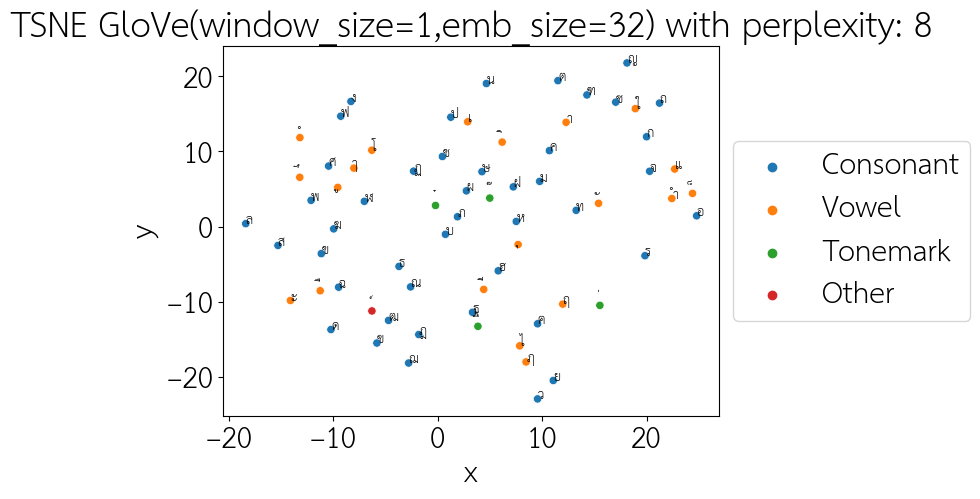

In [ ]:
plot_tsne_from_embed_matrix(embedding,
                            perplexity=8,
                            model_name=f"GloVe({window_size=},{emb_size=})"
                            )

In [ ]:
import json
# Lastly, we ignore
# Save emb matrix as numpy array (.npz)
print(f"{embedding.shape = }")
np.savez("glove_emb_matrix.npz",embedding)

with open("vocabulary.json","w",encoding="utf-8") as f:
  json.dump(vocabulary,f,ensure_ascii=False)

embedding.shape = (69, 32)
